In [1]:
import pandas as pd
import numpy as np
import subprocess
import random
from scipy import stats
import glob
import math
import csv
import sys
import os

import matplotlib.pyplot as plt
from matplotlib import animation
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
plt.rcParams['font.family'] = "serif"
%matplotlib inline

In [2]:
# declarations
base_dir_data = "/ccb/salz8-1/avaraby/tx_noise/data/"
base_dir_out = "/ccb/salz8-1/avaraby/tx_noise/GTEx_aggs/"
out_dir = "/ccb/salz8-1/avaraby/tx_noise/sim_samples/"
hg38_fa = "/home/avaraby1/genomes/human/hg38/hg38_p8.fa"

readlen = 101
num_samples = 1

gff3cols=["seqid","source","type","start","end","score","strand","phase","attributes"]

In [3]:
# Here we need to implement a method for converting TPM information into
# coverage information for polyester
# we can do this by following the REM implementation of the TPM to number of reads conversion

In [3]:
# first load the distribution of the number of reads per sample
readlen_stats = pd.read_csv("/ccb/salz8-1/avaraby/tx_noise/readlen.stats",usecols=["readlen"])
readlen_stats.head()

,readlen
0,60585115.0
1,62097360.0
2,65533065.0
3,65023731.0
4,65535944.0


In [5]:
for i in range(num_samples):
    total_nreads = readlen_stats.sample().iloc[0].readlen
    print(total_nreads)
    
    real = pd.read_csv(out_dir+"real.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
    real["tid"] = real["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
    real["gid"] = real["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
    realt = real[real["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
    reale = real[real["type"]=="exon"].reset_index(drop=True)
    reale["elen"] = reale["end"]-reale["start"]
    reale = reale[["tid","elen"]]
    reale = reale.groupby("tid").agg({"elen":"sum"}).reset_index()
    assert set(realt["tid"])==set(reale["tid"]),"number of transcripts is not the same as number of groupped exons"
    reale = realt.merge(reale,how="left",on="tid")
    tpms = pd.read_csv(out_dir+"real.sample"+str(i)+".exp",names=["tpm"])
    assert len(tpms)==len(reale),"number of tpms different from the number of transcripts"
    reale["tpm"] = tpms["tpm"]

    splicing = pd.read_csv(out_dir+"splicing.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
    splicing["tid"] = splicing["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
    splicing["gid"] = splicing["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
    splicingt = splicing[splicing["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
    splicinge = splicing[splicing["type"]=="exon"].reset_index(drop=True)
    splicinge["elen"] = splicinge["end"]-splicinge["start"]
    splicinge = splicinge[["tid","elen"]]
    splicinge = splicinge.groupby("tid").agg({"elen":"sum"}).reset_index()
    assert set(splicingt["tid"])==set(splicinge["tid"]),"number of transcripts is not the same as number of groupped exons"
    splicinge = splicingt.merge(splicinge,how="left",on="tid")
    tpms = pd.read_csv(out_dir+"splicing.sample"+str(i)+".exp",names=["tpm"])
    assert len(tpms)==len(splicinge),"number of tpms different from the number of transcripts"
    splicinge["tpm"] = tpms["tpm"]

    intronic = pd.read_csv(out_dir+"intronic.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
    intronic["tid"] = intronic["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
    intronic["gid"] = intronic["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
    intronict = intronic[intronic["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
    intronice = intronic[intronic["type"]=="exon"].reset_index(drop=True)
    intronice["elen"] = intronice["end"]-intronice["start"]
    intronice = intronice[["tid","elen"]]
    intronice = intronice.groupby("tid").agg({"elen":"sum"}).reset_index()
    assert set(intronict["tid"])==set(intronice["tid"]),"number of transcripts is not the same as number of groupped exons"
    intronice = intronict.merge(intronice,how="left",on="tid")
    tpms = pd.read_csv(out_dir+"intronic.sample"+str(i)+".exp",names=["tpm"])
    assert len(tpms)==len(intronice),"number of tpms different from the number of transcripts"
    intronice["tpm"] = tpms["tpm"]

    pol = pd.read_csv(out_dir+"pol.sample"+str(i)+".gtf",sep="\t",names=gff3cols)
    pol["tid"] = pol["attributes"].str.split("transcript_id \"",expand=True)[1].str.split("\"",expand=True)[0]
    pol["gid"] = pol["attributes"].str.split("gene_id \"",expand=True)[1].str.split("\"",expand=True)[0]
    polt = pol[pol["type"]=="transcript"][["tid","gid"]].reset_index(drop=True) # intended for order
    pole = pol[pol["type"]=="exon"].reset_index(drop=True)
    pole["elen"] = pole["end"]-pole["start"]
    pole = pole[["tid","elen"]]
    pole = pole.groupby("tid").agg({"elen":"sum"}).reset_index()
    assert set(polt["tid"])==set(pole["tid"]),"number of transcripts is not the same as number of groupped exons"
    pole = polt.merge(pole,how="left",on="tid")

    tpms = pd.read_csv(out_dir+"pol.sample"+str(i)+".exp",names=["tpm"])
    assert len(tpms)==len(pole),"number of tpms different from the number of transcripts"
    pole["tpm"] = tpms["tpm"]
    joined = pd.concat([reale[["tid","elen","tpm"]],splicinge[["tid","elen","tpm"]],intronice[["tid","elen","tpm"]],pole[["tid","elen","tpm"]]],axis=0).reset_index(drop=True)
    joined["theta"] = joined["elen"]*joined["tpm"]
    denom = joined["theta"].sum()
    joined["cor"] = joined["theta"]/denom
    # tids = np.random.choice(joined["tid"],total_nreads,p=joined["cor"])
    # tid_df = pd.DataFrame(tids,columns=["tid"]).groupby("tid").agg({"tid":{"count":"count"}}).reset_index()
    # tid_df.columns = ["tid","count"]
    # now that we have all these values, we 
    joined["cov"] = (joined["cor"]*total_nreads*readlen)/joined["elen"]
    # now we can merge the data to comply with the original ordering
    # and proceed to write it out
    realt.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"real.sample"+str(i)+".exp2",index=False,header=False)
    splicingt.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"splicing.sample"+str(i)+".exp2",index=False,header=False)
    intronict.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"intronic.sample"+str(i)+".exp2",index=False,header=False)
    polt.merge(joined[["tid","cov"]],how="left",on="tid")[["cov"]].to_csv(out_dir+"pol.sample"+str(i)+".exp2",index=False,header=False)

84243837.0


In [194]:
# first need to compute total contribution of each to the gene
realg = reale[["gid","tid","tpm"]].groupby(by="gid").agg({"tid":"count","tpm":"sum"}).reset_index()
realg.columns = ["gid","nt_real","tpm_real"]
splicingg = splicinge[["gid","tid","tpm"]].groupby(by="gid").agg({"tid":"count","tpm":"sum"}).reset_index()
splicingg.columns = ["gid","nt_splicing","tpm_splicing"]
intronicg = intronice[["gid","tid","tpm"]].groupby(by="gid").agg({"tid":"count","tpm":"sum"}).reset_index()
intronicg.columns = ["gid","nt_intronic","tpm_intronic"]
joined = realg.merge(splicingg,on="gid",how="outer",indicator=True)
assert len(joined[joined["_merge"]=="right_only"])==0,"non-matching splicing loci"
joined.drop("_merge",axis=1,inplace=True)
joined = joined.merge(intronicg,on="gid",how="outer",indicator=True)
assert len(joined[joined["_merge"]=="right_only"])==0,"non-matching intronic loci"
joined.drop("_merge",axis=1,inplace=True)
joined["nt_splicing"] = joined.nt_intronic.fillna(0)
joined["tpm_splicing"] = joined.tpm_splicing.fillna(0)
joined["nt_intronic"] = joined.nt_intronic.fillna(0)
joined["tpm_intronic"] = joined.tpm_intronic.fillna(0)
joined["nt_total"] = joined.nt_real+joined.nt_splicing+joined.nt_intronic
joined["tpm_total"] = joined.tpm_real+joined.tpm_splicing+joined.tpm_intronic
joined["frac"] = joined["tpm_real"]/(joined["tpm_real"]+joined["tpm_splicing"])
joined["frac_tpm_real"] = joined.tpm_real/joined.tpm_total
joined["frac_tpm_splicing"] = joined.tpm_splicing/(joined.tpm_real+joined.tpm_splicing)
joined["frac_tpm_intronic"] = joined.tpm_intronic/(joined.tpm_real+joined.tpm_intronic)
# rounding numbers
# joined["tpm_real"] = joined["tpm_real"].apply(np.ceil)
# joined["tpm_splicing"] = joined["tpm_splicing"].apply(np.ceil)
# joined["tpm_intronic"] = joined["tpm_intronic"].apply(np.ceil)
joined["total_tpm_noise"] = joined["tpm_splicing"]+joined["tpm_intronic"]
joined.head()

,gid,nt_real,tpm_real,nt_splicing,tpm_splicing,nt_intronic,tpm_intronic,nt_total,tpm_total,frac,frac_tpm_real,frac_tpm_splicing,frac_tpm_intronic,total_tpm_noise
0,CHS.10,1,14.704000,0.0,10.17395,0.0,0.00000,1.0,24.877950,0.591045,0.591045,0.408955,0.000000,10.17395
1,CHS.100,1,15.184400,0.0,3.80915,0.0,0.00000,1.0,18.993550,0.799450,0.799450,0.200550,0.000000,3.80915
2,CHS.10001,1,4.284060,0.0,38.16840,0.0,0.00000,1.0,42.452460,0.100914,0.100914,0.899086,0.000000,38.16840
3,CHS.10003,4,2.850543,1.0,1.29866,1.0,1.37226,6.0,5.521463,0.687010,0.516266,0.312990,0.324964,2.67092
4,CHS.1001,9,27.314882,1.0,1.31249,1.0,1.00866,11.0,29.636032,0.954153,0.921678,0.045847,0.035612,2.32115


maximum common elemend is: 1.28683


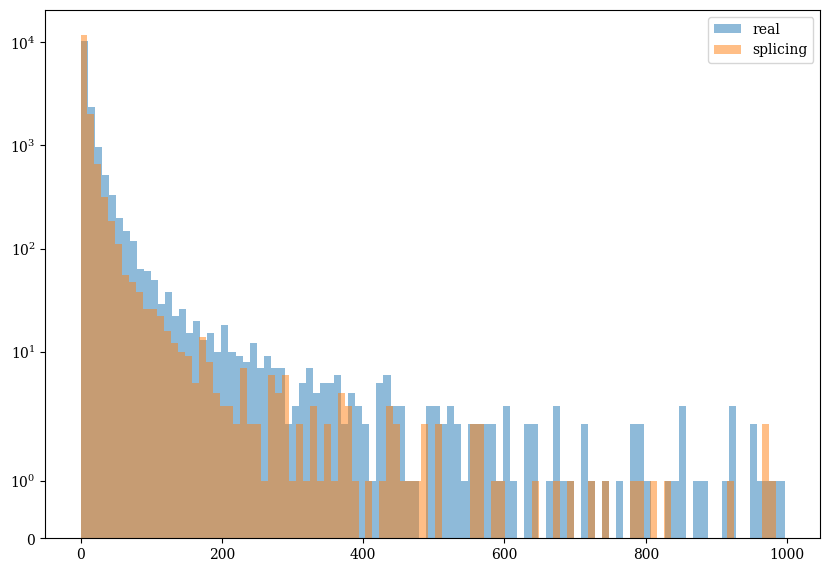

In [195]:
fig = plt.subplots(figsize=(10,7),dpi=100)
max_common = max(list(set(joined["tpm_real"]).intersection(joined["tpm_splicing"]).intersection(joined["tpm_intronic"])))
print("maximum common elemend is: "+str(max_common))
plt.hist(joined[joined["tpm_real"]<1000]["tpm_real"],bins=100,alpha=0.5,label='real')
plt.hist(joined[joined["tpm_splicing"]<1000]["tpm_splicing"],bins=100,alpha=0.5,label='splicing')
# plt.hist(joined[joined["tpm_intronic"]<1000]["tpm_intronic"],bins=100,alpha=0.5,label='intronic')
# plt.hist(joined[joined["total_tpm_noise"]<1000]["total_tpm_noise"],bins=100,alpha=0.5,label='total_noise')
plt.yscale("symlog")
plt.legend(loc='upper right')

No handles with labels found to put in legend.


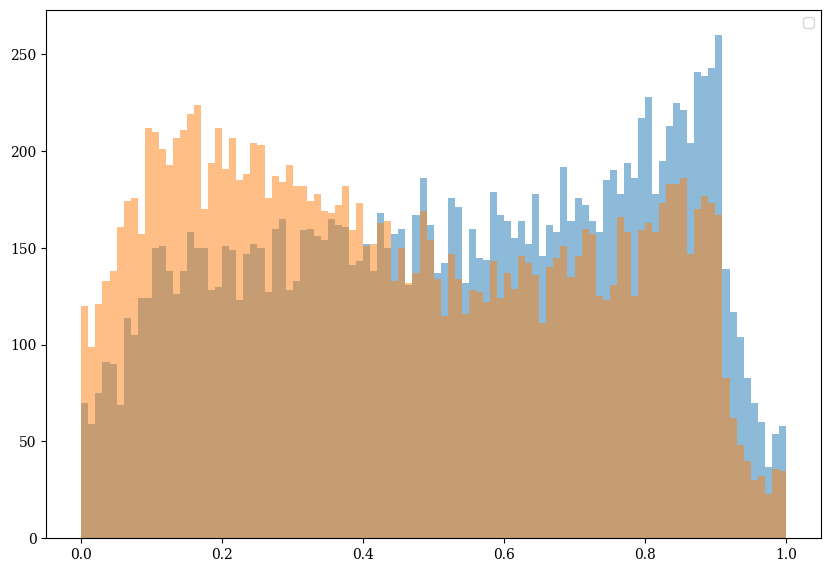

In [196]:
fig = plt.subplots(figsize=(10,7),dpi=100)
plt.hist(joined[joined["frac"]<1.0]["frac"],alpha=0.5,bins=100)
# plt.hist(joined[joined["frac_tpm_real"]<1.0]["frac_tpm_real"],alpha=0.5,bins=100)
# plt.hist(joined[joined["frac"]<1.0]["frac_tpm_splicing"],alpha=0.5,bins=100)
# plt.hist(joined[joined["frac_tpm_intronic"]>0.1]["frac_tpm_intronic"],alpha=0.5,bins=100)
plt.legend(loc='upper right')

In [ ]:
# now to repeat the same for the computed statistics from gtex
sum_df = pd.read_csv(base_dir_out+"res.sum_tx_per_sample_loc")
sum_df = sum_df[sum_df["real"]>0][["real","splicing","intronic"]].reset_index(drop=True)
# now to compare the expression distributions of each
fig1, axes = plt.subplots(ncols=1,nrows=1,figsize=(10,7),dpi=100)

plt.hist(sum_df[sum_df["real"]<10000]["real"],bins=100, alpha=0.5, label='real')
plt.hist(sum_df[sum_df["splicing"]<10000]["splicing"],bins=100, alpha=0.5, label='splicing')
plt.yscale("symlog")
plt.legend(loc='upper right')

In [ ]:
sum_df.head()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8d4c3c7d30>]],
      dtype=object)

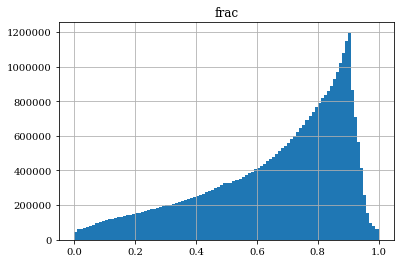

In [113]:
sum_df["frac"] = sum_df["real"]/(sum_df["real"]+sum_df["splicing"]+sum_df["intronic"])
sum_df[sum_df["splicing"]>0].hist("frac",bins=100)

In [114]:
tmp_tx = pd.read_csv(base_dir_out+"res.num_tx_per_sample_loc5")
tmp_tx.head()

/home/avaraby1/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4,5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,real,splicing,intronic,polymerase,tpms_real,tpms_splicing,tpms_intronic,tpms_polymerase
0,0,1,0,0,0,1.90275,0,0
1,1,0,0,0,1.96375,0,0,0
2,2,0,0,0,2.35289;2.45534,0,0,0
3,4,0,0,0,1.07493;1.64786;0.452526;0.428311,0,0,0
4,1,0,0,0,159.706,0,0,0


In [198]:
tmp_tx_pol = tmp_tx[tmp_tx["polymerase"]>0][["polymerase","tpms_polymerase"]]
tmp_tx_nt = tmp_tx[tmp_tx["real"]>0][["real","splicing","intronic"]]
tmp_tx_tpm = tmp_tx[tmp_tx["real"]>0][["tpms_real","tpms_splicing","tpms_intronic"]]

In [123]:
tmp_tx_pol["tpm_total"] = tmp_tx_pol["tpms_polymerase"].str.split(';', expand=True).astype(float).sum(axis=1)
tmp_tx_pol.head()

,polymerase,tpms_polymerase,tpm_total
15549,1,57.2841,57.28410
15550,1,2.37964,2.37964
15551,1,1.66583,1.66583
15552,1,102.842,102.84200
15553,1,2.25518,2.25518


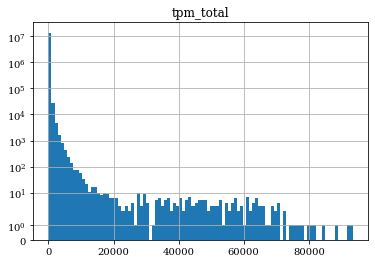

In [126]:
tmp_tx_pol.hist("tpm_total",bins=100)
plt.yscale("symlog")

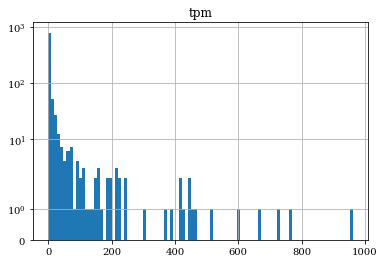

In [127]:
polg = pole[["gid","tid","tpm"]].groupby(by="gid").agg({"tid":"count","tpm":"sum"}).reset_index()
polg.columns = ["gid","nt","tpm"]
polg.hist("tpm",bins=100)
plt.yscale("symlog")

In [ ]:
# tmp_tx_tpm = tmp_tx[tmp_tx["real"]>0][["tpms_real","tpms_splicing","tpms_intronic"]]
tmp_tx_tpm["tpm_total_real"] = tmp_tx_tpm["tpms_real"].str.split(';', expand=True).astype(float).sum(axis=1)
print("processing real")
tmp_tx_tpm["tpm_total_splicing"] = tmp_tx_tpm["tpms_splicing"].str.split(';', expand=True).astype(float).sum(axis=1)
print("processing splicing")
tmp_tx_tpm["tpm_total_intronic"] = tmp_tx_tpm["tpms_intronic"].str.split(';', expand=True).astype(float).sum(axis=1)
tmp_tx_tpm.head()

KeyboardInterrupt: 

Exception ignored in: 'pandas._libs.lib.c_is_list_like'
Traceback (most recent call last):
  File "/home/avaraby1/anaconda3/lib/python3.7/abc.py", line 137, in __instancecheck__
    def __instancecheck__(cls, instance):
KeyboardInterrupt


In [ ]:
tmp_tx_tpm["tpm_total_noise"] = tmp_tx_tpm["tpm_total_splicing"]+tmp_tx_tpm["tpm_total_intronic"]
fig1, axes = plt.subplots(ncols=1,nrows=1,figsize=(10,7),dpi=100)

plt.hist(tmp_tx_tpm[tmp_tx_tpm["tpm_total_real"]<10000]["real"],bins=100, alpha=0.5, label='real')
plt.hist(tmp_tx_tpm[tmp_tx_tpm["tpm_total_splicing"]<10000]["splicing"],bins=100, alpha=0.5, label='splicing')
plt.hist(tmp_tx_tpm[tmp_tx_tpm["tpm_total_ntronic"]<10000]["ntronic"],bins=100, alpha=0.5, label='ntronic')
plt.yscale("symlog")
plt.legend(loc='upper right')